In [2]:
import os
import sys
import warnings

Path = os.path.abspath('../Models/')
if Path not in sys.path: sys.path.append(Path)
warnings.filterwarnings('ignore')
    
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch


hostname = os.uname()
if 'tedtop' in hostname: sys.path.append('/home/fedor-tairli/work/CDEs/Dataset/')


from Dataset2 import ProcessingDatasetContainer



In [145]:
Model_Name   = 'TraceTriggerModelDense_10F10F'
Dataset_Name = 'TracesDataset'

#### Loading Data and Models, Processing Predictions

In [146]:
if 'tycho' in hostname:
    Models_Path  = '/remote/tychodata/ftairli/work/CDEs/PulseTriggering/Models'
    Dataset_Path = '/remote/tychodata/ftairli/work/CDEs/PulseTriggering/Data/'
if 'tedtop' in hostname:
    Models_Path  = '/home/fedor-tairli/work/CDEs/PulseTriggering/Models'
    Dataset_Path = '/home/fedor-tairli/work/CDEs/PulseTriggering/Code/'

# append models path to path
sys.path.append(Models_Path)

In [147]:
# Load Model and Tracker Here
Model = torch.load(f'{Models_Path}/{Model_Name}.pt',weights_only=False)
Tracker = torch.load(f'{Models_Path}/{Model_Name}_Tracker.pt',weights_only=False)
print(Model.Description)


        A Simple trace trigger model with a bottleneck in the middle. 
        The idea is that this time it will produce N features per trace, rather than per bin as above. 
        The Feature will be used to predict signal
        This model has 10 Features.
        


In [148]:
# Import Dataset Here
def Do_Nothing(Truth, *kwargs):
    return Truth
# datapath = '/remote/tychodata/ftairli/work/Projects/ProfileReconstruction/Data/'
# Dataset = ProcessingDatasetContainer(datapath)
Dataset = torch.load(f'{Dataset_Path}/{Dataset_Name}.pt',weights_only=False)
print(Dataset.Name)
print(Dataset.Truth_Keys)
Dataset.AssignIndices()
Dataset.State = 'Test'

TracesDataset
('TraceLikeness',)


In [149]:
# Some Information
print(f'Final Epoch             : {len(Tracker.EpochLoss["Total"])  } ')
if len(Tracker.EpochLoss)>10 :
    print(f'Epoch 10 Loss           : {Tracker.EpochLoss    ["Total"][9]} ')
    print(f'Epoch 10 Validation Loss: {Tracker.EpochValLoss ["Total"][9]} ')
print(f'Final Loss              : {Tracker.EpochLoss    ["Total"][-1]}')
print(f'Final Validation Loss   : {Tracker.EpochValLoss ["Total"][-1]}')


Final Epoch             : 20 
Final Loss              : 589.2790668804614
Final Validation Loss   : 619.8665161132812


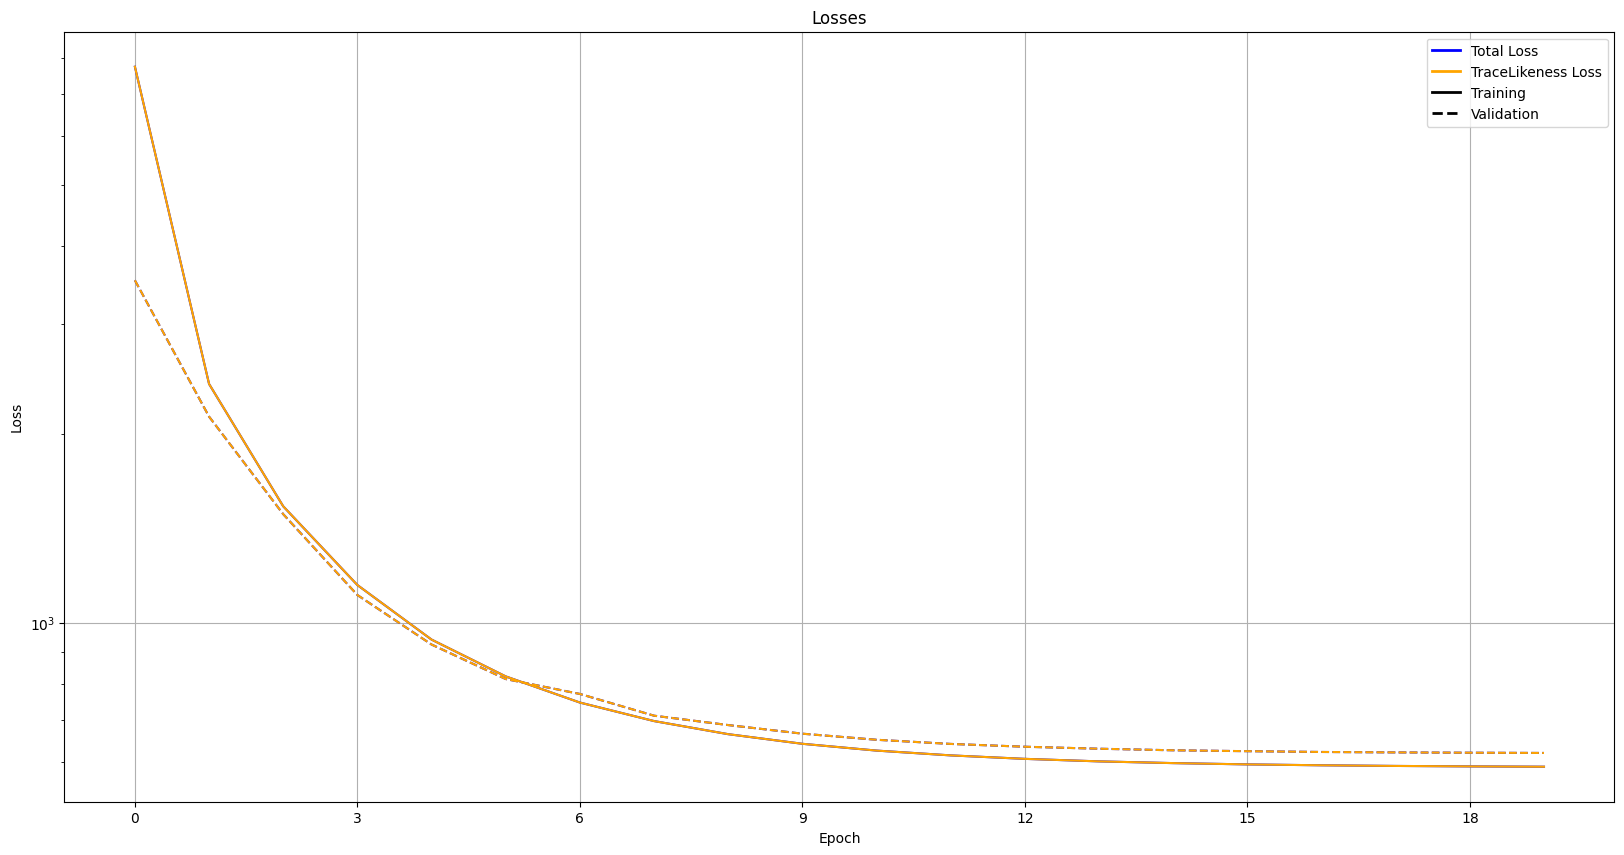

In [150]:
# Loss Plot
EpochLosses    = Tracker.EpochLoss
EpochValLosses = Tracker.EpochValLoss
Keys = list(EpochLosses.keys())
Nepochs = len(EpochLosses[Keys[0]])

ax = plt.figure(figsize=(20, 10)).gca()

# Define colors
colors = ['blue', 'orange', 'green', 'red','cyan','purple','magenta','yellow']


custom_lines = []
custom_keys  = []
for i in range(len(Keys)):
    plt.plot(EpochLosses[Keys[i]]   , color=colors[i], label=Keys[i] + ' - Training')
    plt.plot(EpochValLosses[Keys[i]], color=colors[i], label=Keys[i] + ' - Validation', linestyle='dashed')
    custom_lines.append(Line2D([0], [0], color=colors[i], lw=2))
    custom_keys.append(Keys[i]+' Loss')

custom_lines+= [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='black', lw=2, linestyle='dashed')]
custom_keys += ['Training', 'Validation']


ax.legend(custom_lines, custom_keys)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True)) # integer ticks
ax.set_title('Losses')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.grid()

In [151]:
# Process the Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Model.to(device)
torch.cuda.empty_cache()

Dataset.State = 'Test'
Dataset.BatchSize = 1000
Dataset.RandomIter = False

Truth    = []
Pred     = []
Features = []
# Aux      = []

Model.eval()
EvI = 0
with torch.no_grad():
    for EventIndex, BatchMains, BatchAux, BatchTruth, _ in Dataset:
        print(f'Processing {EvI+1}/{len(Dataset)/Dataset.BatchSize}', end='\r')
        BatchPred     = Model(BatchMains, BatchAux)
        BatchFeatures = Model.get_features(BatchMains, BatchAux)

        Truth   .append(BatchMains[0].cpu())
        Pred    .append(BatchPred    .cpu())
        Features.append(BatchFeatures.cpu())
        # Aux     .append(BatchAux     .cpu())
        EvI += 1
Truth    = torch.cat(Truth   , dim=0).numpy()
Pred     = torch.cat(Pred    , dim=0).numpy()
Features = torch.cat(Features, dim=0).numpy()
# Aux      = torch.cat(Aux     , dim=0).numpy()



In [152]:
print("Truth shape   :", Truth.shape)
print("Pred shape    :", Pred.shape)

if len(Features.shape) == 2:
    Features = Features[:, np.newaxis, :]
    
print("Features shape:", Features.shape)

Truth shape   : (140800, 1, 1000)
Pred shape    : (140800, 1, 1000)
Features shape: (140800, 1, 10)


In [153]:
# Extract the MetaData
MetaData = Dataset._MetaData[Dataset.ActiveIndeces]
MetaData = MetaData.numpy()

In [154]:
# I have everything I need, Free up the memory
torch.cuda.empty_cache()
if 'Model' in globals(): del Model
if 'Dataset' in globals(): del Dataset

WantTraces = 10000000
# Shorten the Data, take the first `WantTraces` traces
if len(Truth) > WantTraces:
    Truth    = Truth   [:WantTraces]
    Pred     = Pred    [:WantTraces]
    Features = Features[:WantTraces]
    MetaData = MetaData[:WantTraces]
    


Random Index: 75271
Features:
[[ 1160.457        8.482031   551.8908      88.06882   -465.18958
    157.96925    -11.952215 -1236.199      377.55817    345.2851  ]]


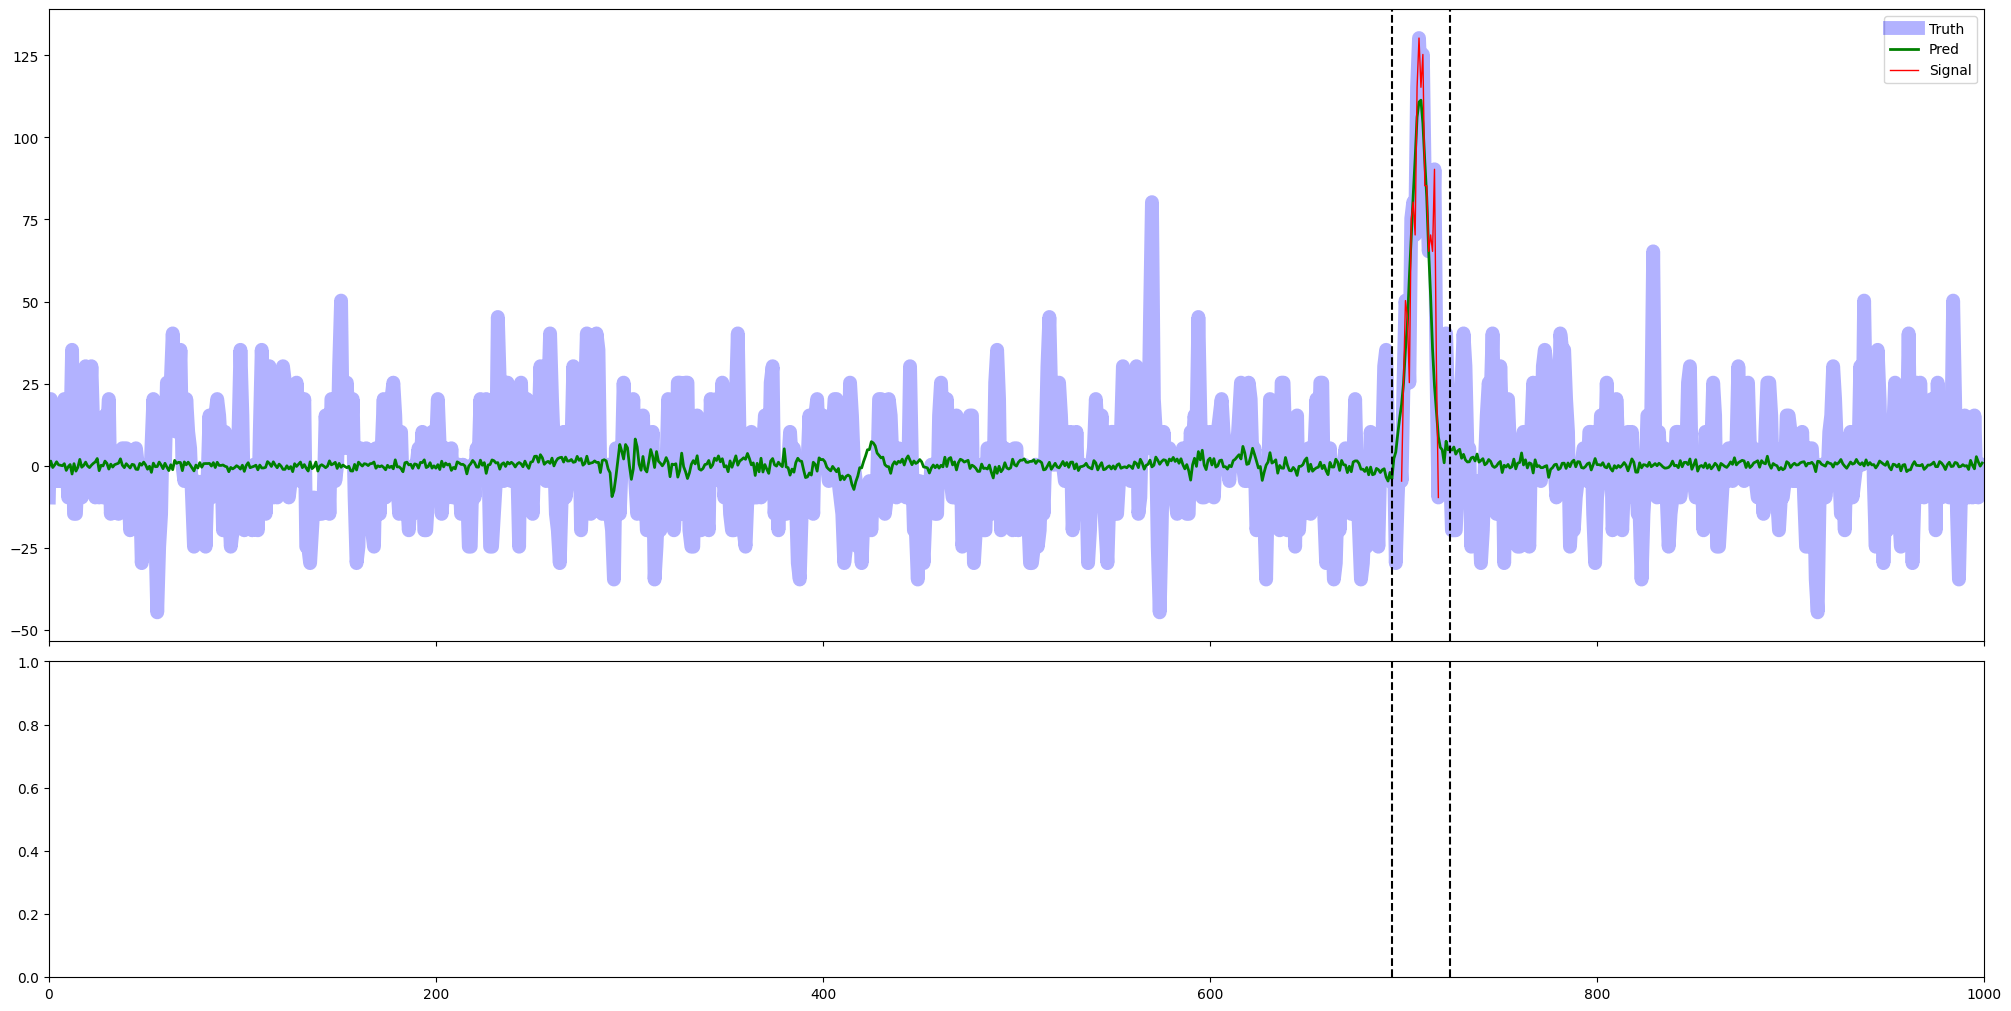

In [164]:
N = np.random.randint(0, len(Truth), 1)[0]
print("Random Index:", N)


# Plot the Trace
SignalStatus = MetaData[N, 0]
SignalStart  = MetaData[N, 1]
SignalEnd    = MetaData[N, 2]
window_size  = 1000

fig,(ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10),
                            sharex=True,
                            gridspec_kw={'height_ratios': [2, 1]},
                            constrained_layout=True
                            )

# Inputs and signal
ax1.plot(Truth[N,0, :]                                                 , label='Truth', color='blue', linewidth=10,alpha = 0.3)
# Model Output
ax1.plot(Pred[N,0, :]                                                  , label='Pred', color='green', linewidth=2,alpha = 1)
ax1.plot(range(SignalStart,SignalEnd),Truth[N,0, SignalStart:SignalEnd], label='Signal', color='red', linewidth=1 )
ax1.legend(loc = 'upper right')

SignalMid = (SignalStart + SignalEnd) // 2
if True and  (SignalMid != 0):
    leftLim  = max(0, SignalMid - window_size)
    rightLim = min(1000, SignalMid + window_size)
    ax1.set_xlim(leftLim, rightLim)

# for i in range(Features.shape[1]):
#     ax2.plot(Features[N,i,:], label=f'Feature {i}', alpha=0.3)
# # plot the absolute sum of the features

# AbsSum = np.abs(Features[N,:,:]).sum(axis=0)
# ax2.plot(AbsSum, label='Absolute Sum', color='black', linewidth=2, alpha=0.5,linestyle='--')
ax2.axvline(SignalStart-5, color='black', linestyle='--', label='Signal Start')
ax2.axvline(SignalEnd  +5, color='black', linestyle='--', label='Signal End')

ax1.axvline(SignalStart-5, color='black', linestyle='--', label='Signal Start')
ax1.axvline(SignalEnd  +5, color='black', linestyle='--', label='Signal End')
# plt.legend(loc = 'upper right')

print("Features:")
print(Features[N,:,:])

In [165]:
Truths_shifted = Truth[:,0,:].copy()
Shift_Amount = MetaData[:, 1]

for i in range(Truths_shifted.shape[0]):
    shift = int(Shift_Amount[i])
    if shift > 0:
        Truths_shifted[i, :-shift] = Truths_shifted[i, shift:]
        Truths_shifted[i, -shift:] = 0
    elif shift < 0:
        Truths_shifted[i, -shift:] = Truths_shifted[i, :shift]
        Truths_shifted[i, :-shift] = 0
# If shift == 0, do nothing


In [175]:
print(Truth.shape)

(140800, 1, 1000)


(array([5.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00, 5.0000e+00,
        8.0000e+00, 7.0000e+00, 1.0000e+01, 1.9000e+01, 3.2000e+01,
        3.0000e+01, 5.0000e+01, 5.6000e+01, 9.7000e+01, 1.6100e+02,
        2.2400e+02, 3.1200e+02, 4.7400e+02, 7.1400e+02, 1.1910e+03,
        1.9830e+03, 3.4710e+03, 6.0930e+03, 1.2077e+04, 1.3583e+04,
        1.2243e+04, 9.9660e+03, 7.8900e+03, 6.8620e+03, 4.8030e+03,
        3.8980e+03, 3.1670e+03, 2.5860e+03, 2.0500e+03, 1.7100e+03,
        1.4240e+03, 1.1540e+03, 9.0300e+02, 8.3200e+02, 7.9200e+02,
        6.3600e+02, 5.5800e+02, 5.8800e+02, 5.6300e+02, 6.3800e+02,
        9.9600e+02, 1.5040e+03, 2.6280e+03, 3.9440e+03, 4.1420e+03,
        3.7840e+03, 3.1770e+03, 2.6670e+03, 2.2300e+03, 1.8130e+03,
        1.5320e+03, 1.2810e+03, 1.1840e+03, 8.7400e+02, 7.5000e+02,
        6.2200e+02, 5.0700e+02, 4.6700e+02, 3.7900e+02, 3.3500e+02,
        3.4400e+02, 2.6200e+02, 2.3800e+02, 1.7200e+02, 1.7500e+02,
        1.4900e+02, 1.3400e+02, 9.7000e+01, 7.20

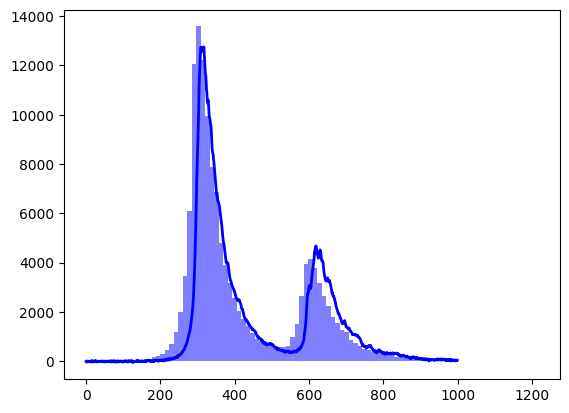

In [187]:
plt.figure()
Average_Truth = np.mean(Truth[:,0,:], axis=0)*240
plt.plot(Average_Truth, label='Average Truth', color='blue', linewidth=2)
plt.hist(Shift_Amount, bins=100, alpha=0.5, color='blue', label='Shift Amount')